In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt 
import torch

from fase.nn.conv import *

### Plain utils

In [3]:
# Test convolution output size
tests = [{'param':{'img_size':(5,5),'kernel_size':(3,3),'stride':1, 'padding':"valid"}, 'out': (3,3)},
         {'param':{'img_size':(5,5),'kernel_size':(3,3),'stride':1, 'padding':"same" }, 'out': (5,5)},
         {'param':{'img_size':(6,6),'kernel_size':(3,3),'stride':1, 'padding':"same" }, 'out': (6,6)},
         {'param':{'img_size':(6,6),'kernel_size':(3,3),'stride':1, 'padding':"valid"}, 'out': (4,4)},
         {'param':{'img_size':(6,6),'kernel_size':(3,3),'stride':2, 'padding':"valid"}, 'out': (2,2)},
         {'param':{'img_size':(5,5),'kernel_size':(3,3),'stride':2, 'padding':"valid"}, 'out': (2,2)},
         {'param':{'img_size':(5,5),'kernel_size':(3,3),'stride':2, 'padding':"same" }, 'out': (3,3)},
         {'param':{'img_size':(5,5),'kernel_size':(5,5),'stride':2, 'padding':"same" }, 'out': (3,3)},
         {'param':{'img_size':(5,5),'kernel_size':(5,5),'stride':2, 'padding':"valid"}, 'out': (1,1)}]

for test in tests:
    assert test['out'] == get_out_size(**test['param']), f"expected = {test['out']}, calculated = {get_out_size(**test['param'])}"
    

Text(0.5, 1.0, 'kernel')

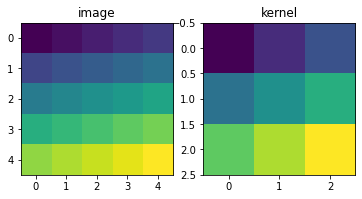

In [44]:
# Load data
if True:
    img = np.arange(5*5, dtype=int).reshape(5,5)
    kernel = np.arange(9).reshape(3,3)
else:
    img = np.array(Image.open("./bird6.png"), dtype=int)
    img = img[:,:,0]

    kernel = np.array([[1,0,-1],
                       [2,0,-2],
                       [1,0,-1]], dtype=int)

nx, ny = img.shape
f_w, f_h = kernel.shape
res = np.zeros((nx,ny), dtype=int) # Same padding

fig, axs = plt.subplots(1,2)
axs[0].imshow(img)
axs[0].set_title("image")
axs[1].imshow(kernel)
axs[1].set_title("kernel")

## 3가지 Convolution (plain)

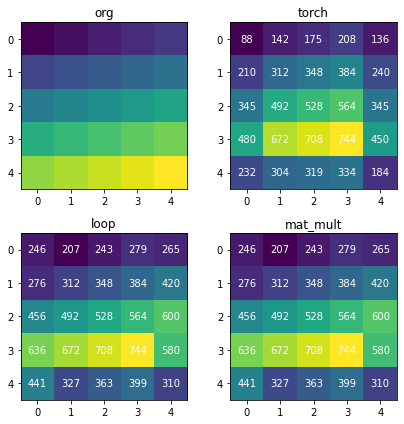

In [45]:
rotated = rotate_input(img, (f_h, f_w))

# 1. simple plain
rkernel = kernel.ravel()
for i, rr in enumerate(rotated):
    if i == 0:
        out = rr * rkernel[i]
    else:
        out += rr * rkernel[i]

# 2. matrix multiplication plain
out_mat = np.matmul(np.stack(rotated).T, kernel.ravel()) # 1024 x 9 * 9 x 1 -> 1024 x 1 
# 가운데 3x3은 맞고, 주변은 음...? 
# padding된 5x5 kernel로 곱해야하는 듯

# 3. torch conv2d
nc = 1
# kernel in 3D (and later 4d) tensor format
filters = repeat_filter(kernel, nc)
res_t = torch.conv2d(torch.tensor(img[np.newaxis, np.newaxis,:,:]), 
             torch.tensor(filters[np.newaxis,:,:,:]), padding=1)
img_t = res_t.squeeze().numpy()

fig, axs = plt.subplots(2,2)
fig.set_size_inches(6,6)
axs = axs.ravel()

axs[0].imshow(img)
annot_heatmap(axs[1], img_t)
annot_heatmap(axs[2], out.reshape(nx, ny))
annot_heatmap(axs[3], out_mat.reshape(nx, ny))

axs[0].set_title("org")
axs[1].set_title("torch")
axs[2].set_title("loop")
axs[3].set_title("mat_mult")

plt.tight_layout()
plt.show()

In [47]:
rotated

[array([19, 20, 21, 22, 23, 24,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
        11, 12, 13, 14, 15, 16, 17, 18]),
 array([20, 21, 22, 23, 24,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,
        12, 13, 14, 15, 16, 17, 18, 19]),
 array([21, 22, 23, 24,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,
        13, 14, 15, 16, 17, 18, 19, 20]),
 array([24,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24,  0]),
 array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
        21, 22, 23, 24,  0,  1,  2,  3]),
 array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
        22, 23, 24,  0,  1,  2,  3,  4]),
 array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 

나는 padding이 안 되고 뭘 한거임? 

# FHE 적용 Convolution

In [6]:
#import fase
from fase.core import seal_ckks
from fase.core.seal_ckks import SEALContext
from fase.seal import Ciphertext

## Polynomial modulus 

어떻게 결정..?

In [7]:
poly_modulus_degree = 16384
coeff_moduli = [37, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 37]

sec = SEALContext(poly_modulus_degree=poly_modulus_degree,
                             coeff_moduli=coeff_moduli,
                             scale_bit=28)

SEAL CKKS scheme is ready


- Image is encrypted and fits in a ciphertext 
- convolution kernel is in plaintext

It's Enc_A * x, **not** W * Enc_x as in a FC layer.

- Kernel이 아니라 Input image가 encrypt되어야 하니까.. encrypt된 걸 rotate 해야함. 
- multByConst에서 0을 곱할 수는 없음. (resulting ciphertext is transparent  error 발생). 0 이면 그냥 무시. 
- 1이어도 곱하기가 필요 없겠지만 scale을 따로 관리해줘야하는 불편함이 있는 반명 CNN filter가 정확히 1이 될 경우가 거의 없을 것라 속도 향상이 작을 것으로 보로 따로 체크하지 않음. 


### rotate 전에 encrypt

문제: img pixel보다 더 많은 slot이 있기 때문에, 뒤쪽 슬롯은 전부 0임. rotate하면 0들이 앞쪽 슬롯으로 들어감.   
해결: 단순 무식한 방법-- 이미지를 두번 반복해두고 시작하기 -- 반드시 left rotate만 있어야함!  
     아니면 더 무식하게 앞, 뒤로 반복해두고 시작..

근데 이렇게 하면 두번째 convolution을 어쩌려고...? mask 씌워서 한번 걸러내면 되긴 함. 

In [9]:
# encrypt first
img_enc = sec.encrypt(img.ravel())

# augment image a
img_aug = sec.add(img_enc, sec._evaluator.rotate_vector(img_enc, -nx*ny, sec.galois_keys))
sec.add(img_aug, sec._evaluator.rotate_vector(img_enc, nx*ny, sec.galois_keys), inplace=True)

augmentation 확인

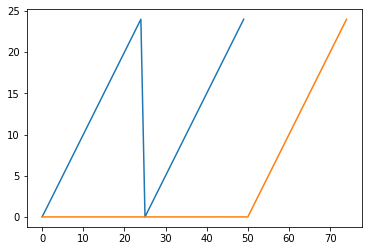

In [10]:
tmp = sec.decrypt(img_aug)

plt.plot(tmp[:2*nx*ny])
plt.plot(tmp[-3*nx*ny:])

In [39]:
# rotate
rotated_ctxt= []
for i in range(f_w):
    for j in range(f_h):
        rotated_ctxt.append(sec._evaluator.rotate_vector(img_aug, (i-1)*nx + (j-1), sec.galois_keys))

In [42]:
rotated_ctxt

In [56]:
rkernel = kernel.ravel()
    
out_fhe = None
out_p = np.zeros(nx*ny, dtype=int)
plain_vk = np.zeros(int(sec.parms.poly_modulus_degree()/2), dtype=int)
for i, rr in enumerate(rotated_ctxt):
    if rkernel[i] == 0:
        continue
    if out_fhe is None:
        plain_vk[:nx*ny] = np.repeat(rkernel[i], nx*ny)
        out_fhe = sec.multByConst(rr, plain_vk, broadcast=False)
    else:
        dec = sec.decrypt(rr)
        plain = np.rint(dec[:nx*ny]).astype(int)
        
        # Keep only relevant part of the augmented img array
        plain_vk[:nx*ny] = np.repeat(rkernel[i], nx*ny)
        sec.add(out_fhe, sec.multByConst(rr, plain_vk, broadcast=False), inplace=True)
        out_p += plain * plain_vk[:nx*ny]#rkernel[i]
        
    #_dec_tmp = sec.decrypt(out_fhe)
    #print(_dec_tmp[:25].astype(int))
        
        
# plain mat_mult
rotated = rotate_input(img, (3,3))
mat_img = np.stack(rotated).T
out_mat = np.matmul(mat_img, kernel.ravel())

# torch
res_t = torch.conv2d(torch.tensor(img[np.newaxis, np.newaxis,:,:]), 
             torch.tensor(kernel[np.newaxis, np.newaxis,:,:]), padding=1)
img_t = res_t.squeeze().numpy()

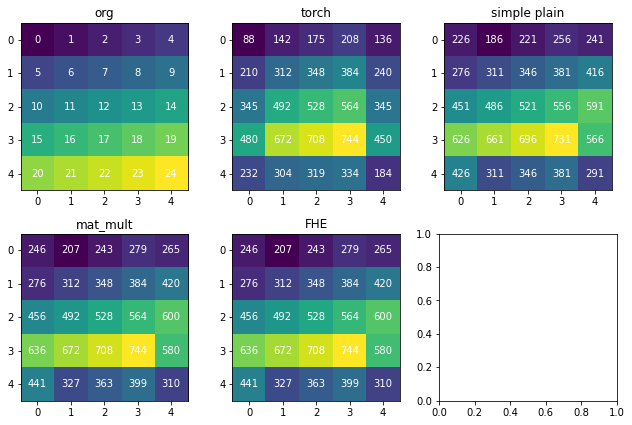

In [58]:
dec = np.rint(sec.decrypt(out_fhe)).astype(int)

res_fhe = dec[:nx*ny].reshape(nx,ny)

fig, axs = plt.subplots(2,3)
fig.set_size_inches(9,6)
axs = axs.ravel()

annot_heatmap(axs[0], img)
annot_heatmap(axs[1], img_t)
annot_heatmap(axs[2], out_p.reshape(nx, ny))
annot_heatmap(axs[3], out_mat.reshape(nx, ny))
annot_heatmap(axs[4], res_fhe)

axs[0].set_title("org")
axs[1].set_title("torch")
axs[2].set_title("simple plain")
axs[3].set_title("mat_mult")
axs[4].set_title("FHE")

plt.tight_layout()
plt.show()

일단 돌아감... 

### convolution 결과 ctxt 모양 유지 됨. 



### 이제 multi-channel...

In [8]:
import torchvision.transforms as transforms

img = np.array(Image.open("./bird6.png"))
to_tensor = transforms.ToTensor() # [n_channel, nh, nw]
img_tensor = to_tensor(img).unsqueeze(0) # [n_batch, n_channel, nh, nw]

print(img_tensor.shape)

torch.Size([1, 3, 32, 32])


In [9]:
# Image in torch tensor format (n_batch, n_channe, n_h, h_w)
n_batch, n_channel, nh, nw = img_tensor.shape

# random 3x3x3 kernel
c_in = 3
c_out = 8 

# Kernel shape of Pytorch convolution: (c_out, c_in, f_h, f_w)
kernel1 = np.array(10*np.random.rand(c_out, c_in, f_h, f_w), dtype=np.float32)#.astype(int)
print(kernel1.shape)

(8, 3, 3, 3)


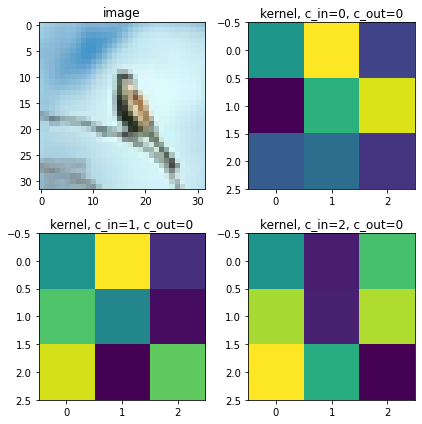

In [10]:
res = np.zeros_like(img, dtype=int) # Same padding

fig, axs = plt.subplots(2,2)
fig.set_size_inches(6,6)
axs = axs.ravel()
axs[0].imshow(img)
axs[0].set_title("image")
axs[1].imshow(kernel1[0,0,:,:])
axs[2].imshow(kernel1[0,1,:,:])
axs[3].imshow(kernel1[0,2,:,:])
axs[1].set_title("kernel, c_in=0, c_out=0")
axs[2].set_title("kernel, c_in=1, c_out=0")
axs[3].set_title("kernel, c_in=2, c_out=0")
plt.tight_layout()
plt.show()

(1, 8, 32, 32)
(8, 32, 32)


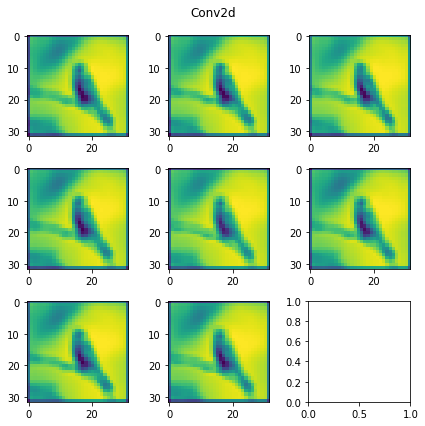

In [11]:
conv_out = my_conv2D(img_tensor, kernel1)

print(conv_out.shape)

# 2. torch conv2d
res_t = torch.conv2d(img_tensor, 
             torch.tensor(kernel1), padding=1)
img_t = res_t.squeeze().numpy()
print(img_t.shape)

fig, axs = plt.subplots(3,3)
fig.set_size_inches(6,6)
axs = axs.ravel()

for i in range(8):
    axs[i].imshow(img_t[i])
    #annot_heatmap(axs[i], img_t[i])

fig.suptitle("Conv2d")
plt.tight_layout()
plt.show()

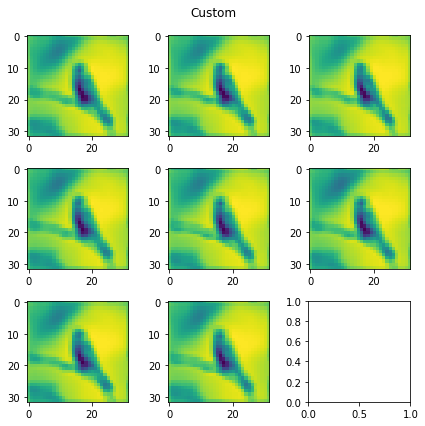

In [12]:
fig, axs = plt.subplots(3,3)
fig.set_size_inches(6,6)
axs = axs.ravel()

for i in range(8):
    axs[i].imshow(conv_out[0][i])
    #annot_heatmap(axs[i], img_t[i])

fig.suptitle("Custom")
plt.tight_layout()
plt.show()

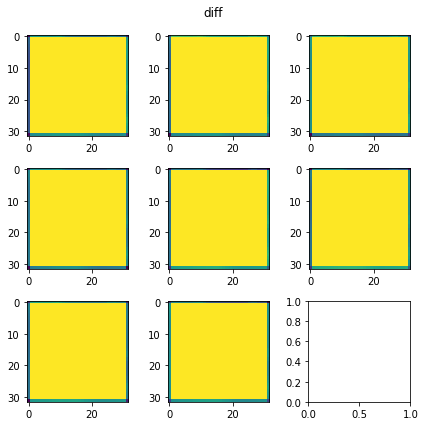

In [13]:
fig, axs = plt.subplots(3,3)
fig.set_size_inches(6,6)
axs = axs.ravel()

for i in range(8):
    axs[i].imshow(img_t[i] - conv_out[0][i])

fig.suptitle("diff")
plt.tight_layout()
plt.show()

In [14]:
(img_t[1] - conv_out[0][1])[10:14,10:14]

array([[ 0.0000000e+00,  0.0000000e+00, -7.6293945e-06, -7.6293945e-06],
       [ 7.6293945e-06, -7.6293945e-06,  0.0000000e+00,  7.6293945e-06],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, -7.6293945e-06],
       [ 0.0000000e+00, -7.6293945e-06, -7.6293945e-06,  0.0000000e+00]],
      dtype=float32)

My implementation is identical to Con2vd except for the outermost shell.

### 이번엔 1,8,32,32 -> 1,16,32,32

In [16]:
#convert list of list to tensor
conv_out = torch.tensor(conv_out)

f_h2 = f_w2 = 3
c_out2 = 16

n_batch, c_in2, nh2, nw2 = conv_out.shape
#stride = 2

kernel2 = np.array(10*np.random.rand(c_out2, c_in2, f_h2, f_w2), dtype=np.float32)

# 1. My convolution
conv_out2 = my_conv2D(conv_out, kernel2)

print(conv_out2.shape)

# 2. torch conv2d
res_t = torch.conv2d(conv_out, 
             torch.tensor(kernel2), padding=1)
img_t2 = res_t.squeeze().numpy()
print(img_t2.shape)

(1, 16, 32, 32)
(16, 32, 32)


/tmp/ipykernel_3738/1875068518.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  conv_out = torch.tensor(conv_out)


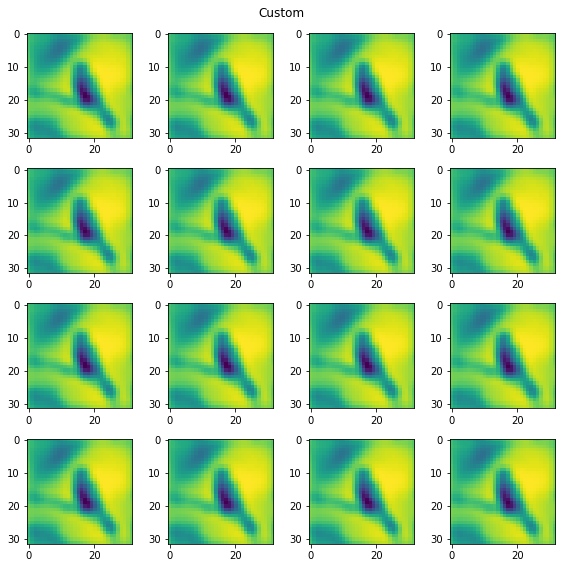

In [17]:
fig, axs = plt.subplots(4,4)
fig.set_size_inches(8,8)
axs = axs.ravel()

for i in range(c_out2):
    axs[i].imshow(conv_out2[0][i])
    #annot_heatmap(axs[i], img_t[i])

fig.suptitle("Custom")
plt.tight_layout()
plt.show()

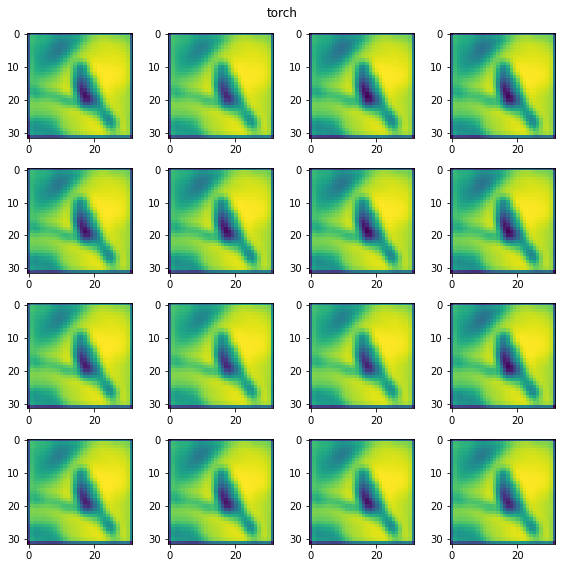

In [18]:
fig, axs = plt.subplots(4,4)
fig.set_size_inches(8,8)
axs = axs.ravel()

for i in range(c_out2):
    axs[i].imshow(img_t2[i])
    #annot_heatmap(axs[i], img_t[i])

fig.suptitle("torch")
plt.tight_layout()
plt.show()

#### Conv2d - My_conv, multi-channel

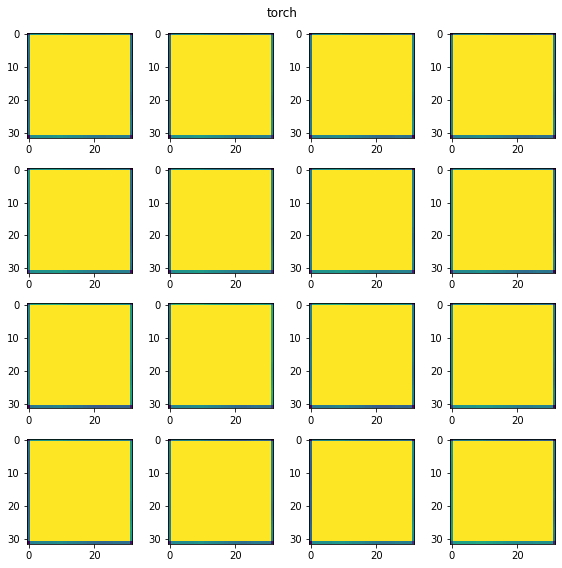

In [19]:
fig, axs = plt.subplots(4,4)
fig.set_size_inches(8,8)
axs = axs.ravel()

for i in range(c_out2):
    axs[i].imshow(img_t2[i] - conv_out2[0][i])

fig.suptitle("torch")
plt.tight_layout()
plt.show()

# 이제 multi-channel FHE

In [20]:
print("input img tensor", img_tensor.shape)

print("multi-channel kernel", kernel1.shape)

input img tensor torch.Size([1, 3, 32, 32])
multi-channel kernel (8, 3, 3, 3)


In [21]:
img_this_example = img_tensor[0] # Assume batch size = 1

img_enc = [sec.encrypt(this_channel.ravel()) for this_channel in img_this_example]

#test = my_conv2D_FHE(sec, img_enc, nh, nw, kernel1)
test = my_conv2D_FHE(sec, img_enc, nh, nw, kernel1)

print(len(test))

Output image size 32 32
8


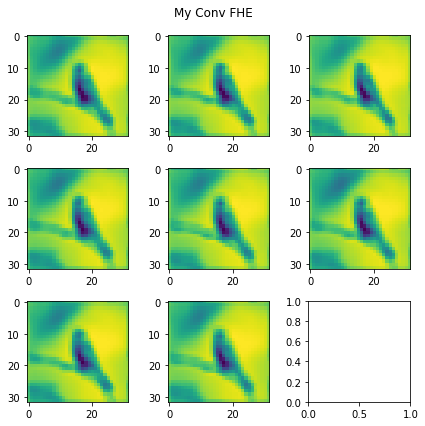

In [22]:
fig, axs = plt.subplots(3,3)
fig.set_size_inches(6,6)
axs = axs.ravel()

for i in range(8):
    dec = sec.decrypt(test[i])
    axs[i].imshow(dec[:nh*nw].reshape(nh,nw))
    #annot_heatmap(axs[i], img_t[i])

fig.suptitle("My Conv FHE")
plt.tight_layout()
plt.show()

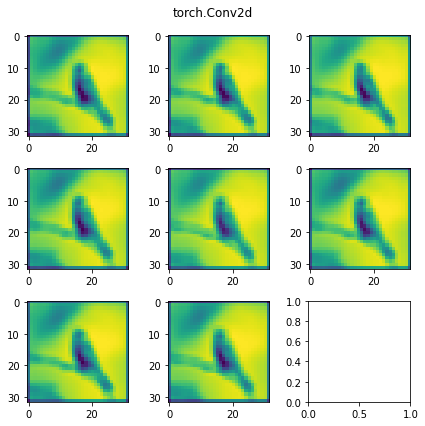

In [23]:
res_t = torch.conv2d(img_tensor, 
             torch.tensor(kernel1), padding=1)
img_t = res_t.squeeze().numpy()

fig, axs = plt.subplots(3,3)
fig.set_size_inches(6,6)
axs = axs.ravel()

for i in range(8):
    axs[i].imshow(img_t[i])

fig.suptitle("torch.Conv2d")
plt.tight_layout()
plt.show()

### diff

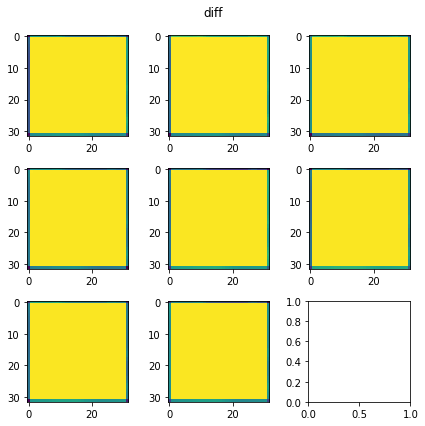

In [24]:
fig, axs = plt.subplots(3,3)
fig.set_size_inches(6,6)
axs = axs.ravel()


for i in range(8):
    dec = sec.decrypt(test[i])
    axs[i].imshow(img_t[i] - dec[:nh*nw].reshape(nh,nw))

fig.suptitle("diff")
plt.tight_layout()
plt.show()

GOOD!

## FHE conv1 & conv2

In [25]:
img_this_example = img_tensor[0] # Assume batch size = 1

img_enc = [sec.encrypt(this_channel.ravel()) for this_channel in img_this_example]

test = my_conv2D_FHE(sec, img_enc, nh, nw, kernel1) # list of ctxts

res_t1 = torch.conv2d(img_tensor, 
             torch.tensor(kernel1), padding=1)

Output image size 32 32


In [26]:
test_2nd = my_conv2D_FHE(sec, test, nh, nw, kernel2)

print(len(test_2nd))

# 2. torch conv2d
res_t2 = torch.conv2d(res_t1, 
             torch.tensor(kernel2), padding=1)
img_t2 = res_t2.squeeze().numpy()
print(img_t2.shape)


Output image size 32 32
16
(16, 32, 32)


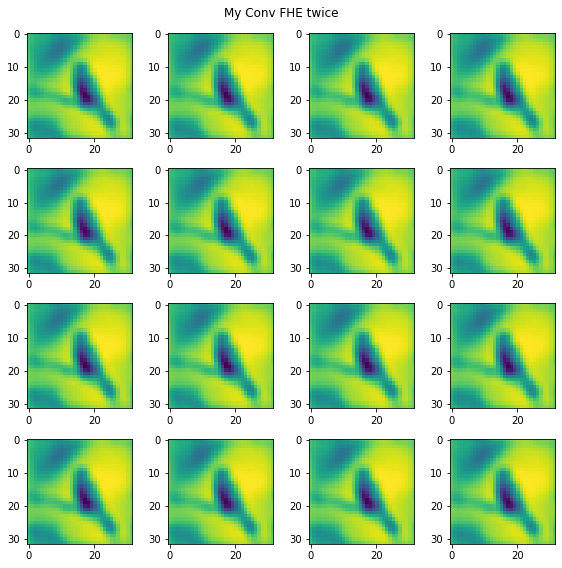

In [27]:
fig, axs = plt.subplots(4,4)
fig.set_size_inches(8,8)
axs = axs.ravel()

for i in range(16):
    dec = sec.decrypt(test_2nd[i])
    axs[i].imshow(dec[:nh*nw].reshape(nh,nw))
    #annot_heatmap(axs[i], img_t[i])

fig.suptitle("My Conv FHE twice")
plt.tight_layout()
plt.show()

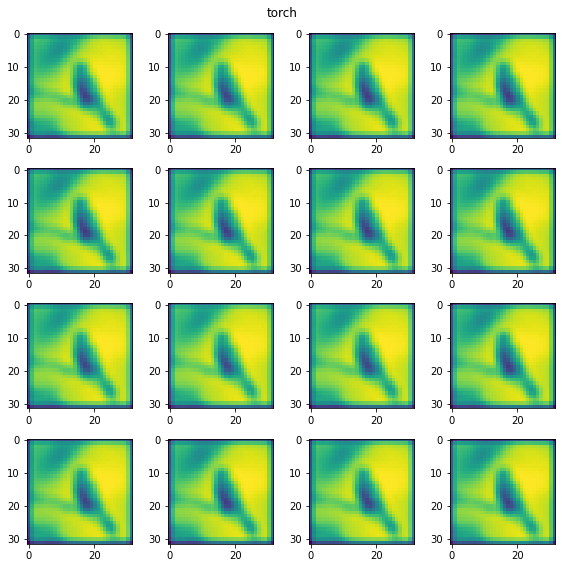

In [28]:
fig, axs = plt.subplots(4,4)
fig.set_size_inches(8,8)
axs = axs.ravel()

for i in range(c_out2):
    axs[i].imshow(img_t2[i])
    #annot_heatmap(axs[i], img_t[i])

fig.suptitle("torch")
plt.tight_layout()
plt.show()

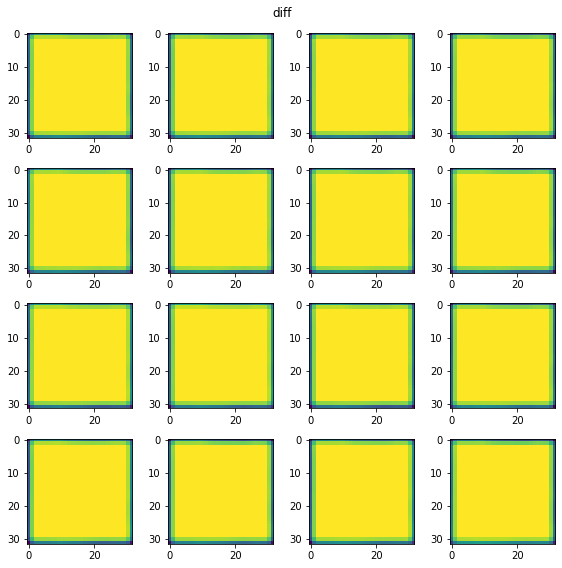

In [29]:
fig, axs = plt.subplots(4,4)
fig.set_size_inches(8,8)
axs = axs.ravel()

for i in range(16):
    dec = sec.decrypt(test_2nd[i])
    axs[i].imshow(img_t2[i] - dec[:nh*nw].reshape(nh,nw))

fig.suptitle("diff")
plt.tight_layout()
plt.show()

## Pytorch 계산과 같은지 확인 

### Pytorch 원래 모델

In [30]:
import torch.nn.functional as F
from torch import nn

def approx_relu(x):
    return 0.47 + 0.5*x + 0.09*x**2

activation = [F.relu, approx_relu, torch.square][1]

class HCNN(nn.Module):    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1) # padding = 0
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.AvgPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)  
        self.pool3 = nn.AvgPool2d(2, 2)
        self.fc1 = nn.Linear(4 * 4 * 128, 256)
        self.fc2 = nn.Linear(256, 10)
        #self.fc3 = nn.Linear(84, 10)
        self.keep=[]
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = activation(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = activation(x)
        x = self.pool2(x)
        x = activation(self.conv3(x))
        x = self.pool3(x)
        
        x = x.view(-1, 4 * 4 * 128)
        x = self.fc1(x)
        #x = activation(self.fc2(x))
        x = self.fc2(x)
        return x

## weight 가져오기  (CNN infer 수정)

In [33]:
import models

fn_param = "Net_3C2F.pt"
trained_param = torch.load(fn_param)
#model = models.CNN_infer(trained_param)

In [34]:
org_model = HCNN()
org_model.load_state_dict(trained_param)
org_model.eval()

HCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

## Batch Normalization

$$y = \frac{x - \mathrm{E}[x]}{\sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta$$

### plain version BN

In [44]:
# each example, each channel 
this_example = x[0]
x_hat = []
for i, this_channel in enumerate(this_example):
    denom = np.sqrt(running_var[i] + eps)
    x_p = this_channel * (gamma[i]/denom) + (beta[i] - (running_mean[i]*gamma[i]/denom))
    x_hat.append(x_p)

### Check result

In [62]:
correct = org_model.bn1(x)

print(correct[0][0] == x_hat[0])

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])


### FHE version

In [131]:
img_this_example = img_tensor[0] # Assume batch size = 1

img_enc = [sec.encrypt(this_channel.ravel()) for this_channel in img_this_example]

tmp1 = my_conv2D_FHE(sec, img_enc, nh, nw, trained_param['conv1.weight'].detach().to("cpu")) # list of ctxts

Output image size 32 32


In [121]:
print("[FHE] after conv1")
sec.decrypt(tmp1[0])[:1024].reshape(32,32)[12:18,12:18]

[FHE] after conv1


array([[-0.08532739, -0.08275541, -0.06456048, -0.05438825, -0.05773858,
        -0.06827725],
       [-0.08632995, -0.08206451, -0.06136633, -0.04822578, -0.05185419,
        -0.05998921],
       [-0.08702835, -0.08173005, -0.0586495 , -0.04141295, -0.04488021,
        -0.05446552],
       [-0.08745246, -0.08227862, -0.0581469 , -0.03663601, -0.03889328,
        -0.05504977],
       [-0.08779927, -0.08365518, -0.06013202, -0.03504756, -0.03132365,
        -0.05121183],
       [-0.08788632, -0.08555923, -0.06518877, -0.03800874, -0.02444286,
        -0.03814924]])

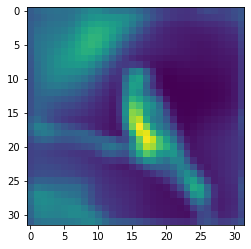

In [122]:
plt.imshow(sec.decrypt(tmp1[0])[:1024].reshape(32,32))

In [100]:
print("[Torch] after conv1")
x[0][0][12:18,12:18]

[Torch] after conv1


tensor([[-0.0853, -0.0828, -0.0646, -0.0544, -0.0577, -0.0683],
        [-0.0863, -0.0821, -0.0614, -0.0482, -0.0519, -0.0600],
        [-0.0870, -0.0817, -0.0587, -0.0414, -0.0449, -0.0545],
        [-0.0875, -0.0823, -0.0581, -0.0366, -0.0389, -0.0551],
        [-0.0878, -0.0837, -0.0601, -0.0350, -0.0313, -0.0512],
        [-0.0879, -0.0856, -0.0652, -0.0380, -0.0244, -0.0382]],
       grad_fn=<SliceBackward0>)

In [132]:
gamma = bn_dict['weight'].detach().cpu().numpy()
beta = bn_dict['bias'].detach().cpu().numpy()
running_mean = bn_dict['running_mean'].detach().cpu().numpy()
running_var = bn_dict['running_var'].detach().cpu().numpy()
eps = 1e-5

# each example, each channel 
x_hat = []
for i, this_channel in enumerate(tmp1):
    denom = np.sqrt(running_var[i] + eps)
    factor = gamma[i]/denom
    const  = (beta[i] - (running_mean[i]*gamma[i]/denom))
    
    sec.multByConst(this_channel, np.repeat(factor, nh*nw), inplace=True)
    sec.addConst(this_channel, np.repeat(const, nh*nw), inplace=True)
    
    x_hat.append(this_channel)

In [111]:
zz = sec.decrypt(x_hat[0])[:1024]
answer = correct[0][0].detach().numpy()
print("Frac. Diff. in Torch and FHE after bn1")
((zz.reshape(nh,nw) - answer)/answer)[12:18,12:18]

Frac. Diff. in Torch and FHE after bn1


array([[-0.00929586, -0.0090183 , -0.007049  , -0.0059454 , -0.00630913,
        -0.00745259],
       [-0.00940407, -0.00894327, -0.00670334, -0.00527522, -0.0056702 ,
        -0.00655375],
       [-0.00947955, -0.00890766, -0.00640853, -0.00453378, -0.00491132,
        -0.00595397],
       [-0.00952527, -0.00896717, -0.00635385, -0.00401299, -0.00425895,
        -0.00601745],
       [-0.0095628 , -0.00911564, -0.00656919, -0.00383955, -0.00343272,
        -0.00560052],
       [-0.00957223, -0.00932124, -0.00711757, -0.00416249, -0.00268079,
        -0.00417789]])

Good enough

In [37]:
# First apply .detach().cpu().numpy() to all tensors.

def fhe_bn(ctxts, bn_dict, eps = 1e-5):
    """
    
    """
    nh = 32
    nw = 32
    
    gamma = bn_dict['weight'].detach().cpu().numpy()
    beta = bn_dict['bias'].detach().cpu().numpy()
    running_mean = bn_dict['running_mean'].detach().cpu().numpy()
    running_var = bn_dict['running_var'].detach().cpu().numpy()
    
    # Per channel
    result = []
    for i, this_channel in enumerate(ctxts):
        denom = np.sqrt(running_var[i] + eps)
        factor = gamma[i]/denom
        const  = (beta[i] - (running_mean[i]*gamma[i]/denom))

        sec.multByConst(this_channel, np.repeat(factor, nh*nw), inplace=True)
        sec.addConst(this_channel, np.repeat(const, nh*nw), inplace=True)

        result.append(this_channel)
        
    return result

In [60]:
img_this_example = img_tensor[0] # Assume batch size = 1

img_enc = [sec.encrypt(this_channel.ravel()) for this_channel in img_this_example]

tmp1 = my_conv2D_FHE(sec, img_enc, nh, nw, trained_param['conv1.weight'].detach().to("cpu")) # list of ctxts

bn_dict1 = org_model.bn1.state_dict()

tmp2 = fhe_bn(tmp1, bn_dict1)

Output image size 32 32


### Avg Pooling

In [61]:
kernel_size = org_model.pool1.kernel_size
pool_kernel = np.tile(1/(kernel_size * kernel_size), 
                         (len(tmp2), len(tmp2), kernel_size, kernel_size))

tmp3 = my_conv2D_FHE(sec, tmp2, nh, nw, pool_kernel, stride=2)

Output image size 16 16


In [64]:
pooled2

array([[-6.97788193e+00,  7.11545661e-07, -6.23029879e+00, ...,
        -7.23295323e-07, -6.02803770e+00, -5.64541859e-07],
       [ 4.45454545e-07,  1.53045373e-07,  2.16387424e-08, ...,
         5.06685326e-07,  1.40896819e-06, -9.98172487e-07],
       [-5.65592565e+00, -3.24027177e-07, -6.08026246e+00, ...,
         8.31091495e-07, -6.22747619e+00,  1.34766580e-07],
       ...,
       [-2.60212445e-07, -1.37772598e-06, -8.32734398e-07, ...,
         3.86484898e-07, -1.18666749e-06,  3.51794162e-07],
       [-6.40544669e+00, -4.12924859e-07, -6.62941047e+00, ...,
        -6.15701125e-07, -6.09024000e+00,  9.20550520e-08],
       [-7.72341609e-07,  8.39730897e-07, -1.18141606e-06, ...,
        -7.88133249e-07,  2.26973249e-08,  3.40111204e-07]])

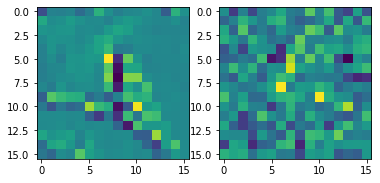

In [69]:
pooled2 = sec.decrypt(tmp3[0])[:nh*nw].reshape(nh,nw)
fig, axs = plt.subplots(1,2)

axs[0].imshow(pooled2[::2,::2])
axs[1].imshow(pooled2[1::2,1::2])

plt.show()

In [54]:
pooled = sec.decrypt(tmp3[0])[:nh*nw].reshape(nh,nw)

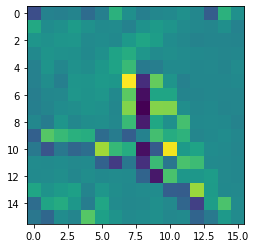

In [55]:
plt.imshow(pooled[::2,::2])

In [59]:
kernel = pool_kernel
img_enc = tmp2

def my_conv2D_FHE(sec, img_enc, nh, nw, kernel, stride=1, padding="same"):
    c_out, c_in, f_h, f_w = kernel.shape

    out_nh, out_nw = get_out_size((nh, nw), (f_h, f_w), 
                                  stride=stride, 
                                  padding=padding)

    print("Output image size", out_nh, out_nw)

    # rotate each channel
    rotated =[]
    for channel_enc in img_enc:
        img_aug = aug_ctxt(channel_enc, nh, nw, sec)
        rotated.append(rotate_for_conv(img_aug, nw, f_h, f_w, sec))

    mask = np.zeros(int(sec.parms.poly_modulus_degree()/2), dtype=int)
    if stride == 1:
        mask[:nw*nh] = np.ones(nw*nh)
    else :
        _mask = np.zeros((nw,nh))
        _mask[::stride,::stride] = 1.
        mask[:nw*nh] = _mask.ravel()

    conv_out=[]
    #for this_example in rotated:
    for this_kernel_in_channel in kernel:
        # 0 - c_out
        # multi-channel conv sum

        # convolve each channel of image and kernel
        result_each_out_channel = None
        for this_channel, this_kernel in zip(rotated, this_kernel_in_channel):
            # 0 - c_in
            if result_each_out_channel == None:
                result_each_out_channel = convolve_fhe(this_channel, this_kernel, sec)
                #print(sec.decrypt(result_each_out_channel)[:nh*nw].reshape(nh,nw)[14:16,14:16])
            else:
                sec.add(result_each_out_channel,
                        convolve_fhe(this_channel, this_kernel, sec), inplace=True)

            # Can I keep doing addition? do I need to do relinearization or...?

        # leave only original part of the image
        sec.multByConst(result_each_out_channel, mask, broadcast=False, inplace=True)
        conv_out.append(result_each_out_channel)

    return conv_out

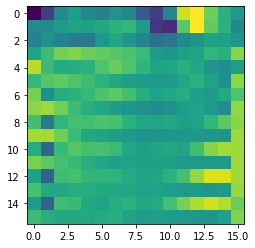

In [154]:
nh2 = 16
nw2 = 16
plt.imshow(sec.decrypt(tmp3[0])[:nh2*nw2].reshape(nh2,nw2))

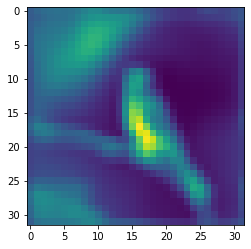

In [138]:
plt.imshow(sec.decrypt(tmp2[0])[:nh*nw].reshape(nh,nw))#[14:18,14:18]


In [ ]:
tmp1[]

In [26]:
org_model.parameters

<bound method Module.parameters of HCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)>

## reconstruct original model structure

-- 파라미터 저장 순서가 항상 원래의 모델 순서와 동일한가?? 

-- Pytorch도 원본 모델 class를 필요로 하는데 나라고 그거 없이 해야할 이유가 있을까?.. 없지! 

In [70]:
trained_param['fc1.weight'].shape

torch.Size([256, 2048])

In [71]:
trained_param['fc1.bias'].shape

torch.Size([256])

## Batch normalization

**Need to pass image size to every layer!

BN additionally requires the batch size -- can be inferred from the weight

In [16]:
img_this_example = img_tensor[0] # Assume batch size = 1

img_enc = [sec.encrypt(this_channel.ravel()) for this_channel in img_this_example]

tmp1, nh2, nw2 = my_conv2D_FHE(sec, img_enc, nh, nw, trained_param['conv1.weight'].detach().to("cpu")) # list of ctxts

tmp2 = fhe_bn(tmp1, )

test_2nd = my_conv2D_FHE(sec, tmp1, nh, nw, trained_param['conv2.weight'].detach().to("cpu"))



print(len(test_2nd))

Output image size 32 32


ValueError: too many values to unpack (expected 3)

In [110]:
aa = trained_param['conv2.weight'].detach().cpu().numpy().ravel()

plt.hist(np.log10(np.abs(aa)))

In [17]:
x = org_model.conv1(img_tensor)

In [77]:
x.shape

torch.Size([1, 32, 32, 32])

In [78]:
res_t1.shape

torch.Size([1, 8, 32, 32])

In [72]:
x = org_model.bn1(x)
x = activation(x)
x = org_model.pool1(x)

x = org_model.conv2(x)
x = org_model.bn2(x)
x = activation(x)
x = org_model.pool2(x)
x = activation(org_model.conv3(x))
x = org_model.pool3(x)

x = x.view(-1, 4 * 4 * 128)
x = org_model.fc1(x)
#x = activation(org_model.fc2(x))
x = org_model.fc2(x)

In [62]:
print(org_model(img_tensor))
print(np.argmax(org_model(img_tensor).detach().numpy())) # 8 = ship... WRONG!

tensor([[ 1.9156e+00, -4.5083e+00,  3.2347e-01,  1.2243e+00, -6.0580e-01,
          3.4226e-03, -9.6933e-01, -6.7847e-01,  2.6810e+00,  6.4274e-01]],
       grad_fn=<AddmmBackward0>)
8


In [86]:
trained_param.keys()

odict_keys(['conv1.weight', 'conv1.bias', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'conv2.weight', 'conv2.bias', 'bn2.weight', 'bn2.bias', 'bn2.running_mean', 'bn2.running_var', 'bn2.num_batches_tracked', 'conv3.weight', 'conv3.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])

In [89]:
trained_param['conv1.weight'].shape

torch.Size([32, 3, 3, 3])

In [94]:
# 2. torch conv2d
res_t1 = torch.conv2d(img_tensor, 
             torch.tensor(trained_param['conv1.weight'].to("cpu")), padding=1)

res_t2 = torch.conv2d(res_t1, 
             torch.tensor(trained_param['conv2.weight'].to("cpu")), padding=1)
img_t2 = res_t2.squeeze().numpy()
print(img_t2.shape)

(64, 32, 32)


/tmp/ipykernel_9554/756997450.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(trained_param['conv1.weight'].to("cpu")), padding=1)
/tmp/ipykernel_9554/756997450.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(trained_param['conv2.weight'].to("cpu")), padding=1)


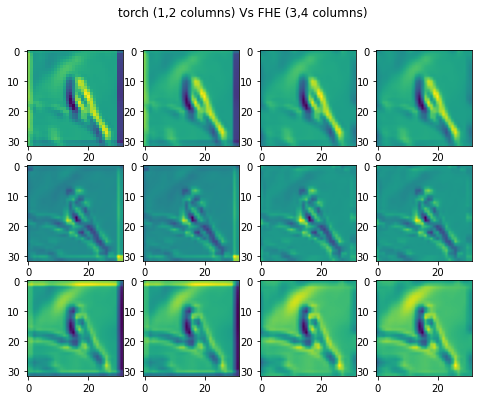

In [126]:
fig, axs = plt.subplots(3,4)
fig.set_size_inches(8,6)
# Pytorch
for i in range(2):
    for j in range(3):
        axs[j,i].imshow(img_t2[j])


decs2 = [sec.decrypt(tt)[:nh*nw] for tt in test_2nd]
        
# MyConvFHE
for i in range(2,4):
    for j in range(3):
        axs[j,i].imshow(decs2[j].reshape(nh,nw))
        
fig.suptitle("torch (1,2 columns) Vs FHE (3,4 columns)")
plt.show()

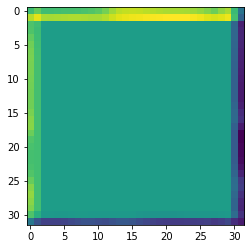

In [136]:
plt.imshow((img_t2[20] - decs2[20].reshape(nh,nw)))

테두리 빼곤 동일. 통과

## CNN 모델

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1) # padding = 0
        #self.bn1 = nn.BatchNorm2d(8)
        self.pool1 = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool2 = nn.AvgPool2d(2, 2)
        
        
### 1. multi-channel
### 2. padding
### 3. stridding (== avg pool)

JoonWoo-Lee 2021

### packed SISO

### multi-channel

GAZELLE은 channel packing을 어떻게 했는가?

In [121]:
from fase.core import matrix_seal

In [118]:
import importlib

In [123]:
importlib.reload(matrix_seal)

<module 'fase.core.matrix_seal' from '/home/hoseung/Work/fhe-ai-sw-etri/fase/core/matrix_seal.py'>

In [125]:
mm = matrix_seal.Seal_matmult(sec)

In [ ]:
mm()

imag를 rotate해놨는데, kernel을 또 rotate하면서 곱한다?? 

In [126]:
from fase import seal

In [128]:
from typing import List
def matrix_multiply_diagonals(diagonals: List[seal.Plaintext], ctx: seal.Ciphertext,
                              evaluator: seal.Evaluator, galois_keys: seal.GaloisKeys):
    output = seal.Ciphertext()

    for i in range(len(diagonals)):

        temp = seal.Ciphertext()
        diagonal = diagonals[i]

        temp = evaluator.rotate_vector(ctx, i, galois_keys)

        evaluator.mod_switch_to_inplace(diagonal, temp.parms_id())
        evaluator.multiply_plain_inplace(temp, diagonal)
        evaluator.rescale_to_next_inplace(temp)

        if i == 0:
            output = temp
        else:
            evaluator.add_inplace(output, temp)

    return output
